# 📌 First exploratory analysis of NOAA AIS 2024 dataset and deep learning approaches to infer ocean currents using Mercator Global Operational Ocean Analysis data.
---
## 🚢 AIS Data:
This notebook uses the **NOAA AIS (Automatic Identification System) 2024 dataset**, available on Kaggle:  
🔗 [2024 NOAA AIS Dataset](https://www.kaggle.com/datasets/bwandowando/2024-us-coast-guard-noaa-ais-dataset)

AIS is an automatic tracking system used on ships and by vessel traffic services (VTS) to provide real-time information on vessel identity, position, course, and speed.  
The dataset is sourced from the **U.S. Coast Guard National Automatic Identification System** and covers maritime traffic for the year 2024.

The dataset is provided in **compressed Parquet format**.  
Each record corresponds to an AIS message and includes:
| #  | Name             | Description                                      | Example        | Units                | Resolution   | Type     | Size  |
|----|------------------|--------------------------------------------------|----------------|----------------------|--------------|----------|-------|
| 1  | MMSI             | Maritime Mobile Service Identity value           | 477220100      | -                    | -            | Text     | 8     |
| 2  | BaseDateTime     | Full UTC date and time                           | 2017-02-01T20:05:07 | -               | YYYY-MM-DD:HH-MM-SS | DateTime | -     |
| 3  | LAT              | Latitude                                         | 42.35137       | decimal degrees      | XX.XXXXX     | Double   | 8     |
| 4  | LON              | Longitude                                        | -71.04182      | decimal degrees      | XXX.XXXXX    | Double   | 8     |
| 5  | SOG              | Speed Over Ground                                | 5.9            | knots                | XXX.X        | Float    | 4     |
| 6  | COG              | Course Over Ground                               | 47.5           | degrees              | XXX.X        | Float    | 4     |
| 7  | Heading          | True heading angle                               | 45.1           | degrees              | XXX.X        | Float    | 4     |
| 8  | VesselName       | Name as shown on the station radio license       | OOCL Malaysia  | -                    | -            | Text     | 32    |
| 9  | IMO              | International Maritime Organization Vessel number| IMO9627980     | -                    | -            | Text     | 16    |
| 10 | CallSign         | Call sign as assigned by FCC                     | VRME7          | -                    | -            | Text     | 8     |
| 11 | VesselType       | Vessel type as defined in NAIS specifications    | 70             | -                    | -            | Integer  | short |
| 12 | Status           | Navigation status as defined by the COLREGS      | 3              | -                    | -            | Integer  | short |
| 13 | Length           | Length of vessel (see NAIS specifications)       | 71.0           | meters               | XXX.X        | Float    | 4     |
| 14 | Width            | Width of vessel (see NAIS specifications)        | 12.0           | meters               | XXX.X        | Float    | 4     |
| 15 | Draft            | Draft depth of vessel (see NAIS specifications)  | 3.5            | meters               | XXX.X        | Float    | 4     |
| 16 | Cargo            | Cargo type (see NAIS specification and codes)    | 70             | -                    | -            | Text     | 4     |
| 17 | TransceiverClass | Class of AIS transceiver                         | A              | -                    | -            | Text     | 2     |


---

## 🌊 Ocean Currents Data:
In this project, we use the Mercator global ocean reanalysis, which provides high-resolution (1/12°) 3D fields of temperature, salinity, currents, sea level, mixed layer depth, ice parameters, and a dedicated surface current dataset (SMOC) integrating wave and tidal drift.
🔗 [DOI (product)](https://doi.org/10.48670/moi-00016)


## 🎯 Objective:
In this project, we aim to compare the ocean current fields provided by the Operational Mercator model with vessel motion signals from the AIS dataset.
The goal is to explore whether a different Neural Network can be trained to infer marine currents directly from AIS-derived navigation signals (SOG, COG, heading, trajectories), opening the way to data-driven current estimation using ship traffic observations.


---

## 🛠️ Required Libraries
```python
...

In [ ]:
! touch /content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/models/ml_utils.py

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import sys
import os
import pyarrow.parquet as pq

project_dir = os.path.abspath("/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project")
sys.path.append(project_dir)

from src.processing import extract_date_components

In [3]:
# =======================
# 📅 Study Period – Starting from the First Day of the Month
# =======================

dataset_datetime_series = pd.Series(['2024-01-01'])

# =======================
# 🌍 Study Area Location
# =======================

LON_MIN, LON_MAX = -102.0, -81.0
LAT_MIN, LAT_MAX = 17.5, 32

# =======================
# 🚢 Boat Parameters
# =======================
SOG_MIN, SOG_MAX = 8.0, 30.0
VALID_TYPES = [70, 71, 72, 80, 60]

In [4]:
YEAR, MONTH_NUM, MONTH_ABBR = extract_date_components(dataset_datetime_series)

print(f"Year: {YEAR}, Month Number: {MONTH_NUM}, Month Abbreviation: {MONTH_ABBR}")

KAGGLE_DATASET = f"bwandowando/{YEAR}-us-coast-guard-noaa-ais-dataset"
SRC_AIS_FILE = f"{YEAR}_NOAA_AIS_logs_{MONTH_NUM}.parquet"     # ex: 2024_NOAA_AIS_logs_01.parquet
SRC_SHIP_FILE = f"{YEAR}_NOAA_AIS_ships_{MONTH_NUM}.parquet"    # ex: 2024_NOAA_AIS_ships_01.parquet
DST_DIR = f"/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/data/AIS{YEAR}"
DST_AIS_FILE = f"NOAA_AIS_{MONTH_ABBR}_{YEAR}.parquet"         # ex: NOAA_AIS_JAN_2024.parquet
DST_SHIP_FILE = f"NOAA_SHIPS_{MONTH_ABBR}_{YEAR}.parquet"
MERCATOR_FILE = f"/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/data/Mercator/mercator_{MONTH_ABBR}_{YEAR}.nc"

print("=" * 50)
print(f"📅  Year: {YEAR} | Month: {MONTH_NUM} ({MONTH_ABBR})")
print("-" * 50)
print(f"📦 Kaggle Dataset : {KAGGLE_DATASET}")
print(f"📄 Source Logs    : {SRC_AIS_FILE}")
print(f"📄  Source Ships  : {SRC_SHIP_FILE}")
print(f"📁 Output Logs    : {DST_AIS_FILE}")
print(f"📁 Output Ships   : {DST_SHIP_FILE}")
print(f"🌊 Mercator  : {MERCATOR_FILE}")
print("=" * 50)

Year: 2024, Month Number: 01, Month Abbreviation: JAN
📅  Year: 2024 | Month: 01 (JAN)
--------------------------------------------------
📦 Kaggle Dataset : bwandowando/2024-us-coast-guard-noaa-ais-dataset
📄 Source Logs    : 2024_NOAA_AIS_logs_01.parquet
📄  Source Ships  : 2024_NOAA_AIS_ships_01.parquet
📁 Output Logs    : NOAA_AIS_JAN_2024.parquet
📁 Output Ships   : NOAA_SHIPS_JAN_2024.parquet
🌊 Mercator  : /content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/data/Mercator/mercator_JAN_2024.nc


# 1. Loading NOAA AIS & Mercator Datasets

# AIS

In [ ]:
# ============================================
# Downloading AIS / Ship Data - AIS Deep Learning Project
# ============================================

# Install Kaggle package
! pip install -q kaggle

# Create Kaggle folder
! mkdir ~/.kaggle

# Copy kaggle.jason fron Google Drive
! cp '/content/drive/MyDrive/KaggleAPI/kaggle.json' ~/.kaggle/

# Give right
! chmod 600 ~/.kaggle/kaggle.json

# Download dataset
! mkdir -p {DST_DIR}
! kaggle datasets download -d {KAGGLE_DATASET} -f {SRC_AIS_FILE}
! kaggle datasets download -d {KAGGLE_DATASET} -f {SRC_SHIP_FILE}


#! unzip {DST_DIR}/{SRC_FILE} -d {DST_DIR} ! mv -f {DST_DIR}/{SRC_FILE} {DST_DIR}/{DST_FILE} ### Not for data > 2022
! mv -f {SRC_AIS_FILE} {DST_DIR}/{DST_AIS_FILE}
! mv -f {SRC_SHIP_FILE} {DST_DIR}/{DST_SHIP_FILE}

Dataset URL: https://www.kaggle.com/datasets/bwandowando/2024-us-coast-guard-noaa-ais-dataset
License(s): CC0-1.0
 99% 2.89G/2.93G [00:54<00:00, 59.7MB/s]
100% 2.93G/2.93G [00:54<00:00, 57.5MB/s]
Dataset URL: https://www.kaggle.com/datasets/bwandowando/2024-us-coast-guard-noaa-ais-dataset
License(s): CC0-1.0
  0% 0.00/871k [00:00<?, ?B/s]
100% 871k/871k [00:00<00:00, 1.20GB/s]


In [ ]:
# ============================================
# Test Data Import - AIS Deep Learning Project
# ============================================


# --- AIS DATA ---
ais_path = os.path.join(DST_DIR, DST_AIS_FILE)
pf = pq.ParquetFile(ais_path)

n_rows = pf.metadata.num_rows
print("--- AIS DATA ---")
print("File:", ais_path)
print("Total rows   :", n_rows)
print("Row groups   :", pf.num_row_groups)

# First chunk reading
chunk = pf.read_row_group(0).to_pandas()
display(chunk.head())

# --- SHIP DATA ---
ship_path = os.path.join(DST_DIR, DST_SHIP_FILE)
df_ship = pd.read_parquet(ship_path)

print("\n--- SHIP DATA ---")
print("File:", ship_path)
print("Total rows   :", len(df_ship))
display(df_ship.head())


--- AIS DATA ---
File: /content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/data/AIS2024/NOAA_AIS_JAN_2024.parquet
Total rows   : 221952082
Row groups   : 212


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,Status
0,210185000,2024-01-01,38.04296,-122.13212,0.0,238.8,234.0,5.0
1,219130000,2024-01-01,41.49499,-125.24296,18.0,179.7,181.0,0.0
2,219412000,2024-01-01,29.74433,-95.09800,0.0,93.0,319.0,5.0
3,229081000,2024-01-01,17.74763,-66.70100,0.4,172.0,94.0,0.0
4,232017152,2024-01-01,46.91665,-124.12713,9.3,228.8,227.0,0.0



--- SHIP DATA ---
File: /content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/data/AIS2024/NOAA_SHIPS_JAN_2024.parquet
Total rows   : 33635


,MMSI,VesselName,IMO,CallSign,VesselType,Length,Width,Draft,Cargo,TransceiverClass,BaseDateTime
0,0,CG49420,<Unknown>,NWHE,51.0,82.0,12.0,1.6,51.0,B,2024-01-01 00:01:59
1,1,EVENING STAR,IMO0000000,WCV5672,30.0,21.0,6.0,2.0,90.0,B,2024-01-27 23:10:45
2,8,29,<Unknown>,<Unknown>,70.0,78.0,0.0,1.1,0.0,A,2024-01-31 16:57:25
3,11,CONSTITUTION,IMO0000007,GC 680,90.0,53.0,38.0,0.0,90.0,A,2024-01-06 02:26:19
4,111,BOOMVANG,IMO0000001,EB643,90.0,47.0,35.0,0.0,90.0,A,2024-01-06 01:35:07


# Mercator

In [ ]:
# Dependencies
! pip install copernicusmarine

import copernicusmarine
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import xarray as xr
import numpy as np

In [ ]:
# ============================================
# Downloading Mercator Data - AIS Deep Learning Project
# ============================================


start_date = pd.to_datetime(dataset_datetime_series)[0]
end_date = start_date + relativedelta(months=1)

xr_mercator = copernicusmarine.open_dataset(
  username='TO COMPLETE',
  password='TO COMPLETE',
  dataset_id="cmems_mod_glo_phy_anfc_0.083deg_PT1H-m",
  variables=["uo", "vo"],
  minimum_longitude=LON_MIN,
  maximum_longitude=LON_MAX,
  minimum_latitude=LAT_MIN,
  maximum_latitude=LAT_MAX,
  start_datetime=start_date,
  end_datetime=end_date,
  minimum_depth=0.49402499198913574,
  maximum_depth=0.49402499198913574,
)

#Download file.nc for processing animation
xr_mercator.to_netcdf(MERCATOR_FILE)

INFO - 2025-10-18T15:47:27Z - Selected dataset version: "202406"
INFO:copernicusmarine:Selected dataset version: "202406"
INFO - 2025-10-18T15:47:27Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"


# 2./ Preprocessing Pipeline for Machine Learning

In [ ]:
# Dependencies

! apt-get install -y libproj-dev proj-data proj-bin \
                    libgeos-dev
! pip install --quiet cartopy
%pip -q install cartopy xarray netCDF4 cftime matplotlib numpy pandas

import pandas as pd
import sys
import os
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project"))

from src.ais_filter import create_filtered_ais
from src.ship_filter import create_filtered_ship
from src.sampled_ais_map import sampled_maps
from src.merged_ais_ship import create_merged_ais_ship, plot_merged_ais_ship, polar_histogram_with_stats, advanced_polar_analysis
from src.merged_filter import create_merged_dataset

ais_path = os.path.join(DST_DIR, DST_AIS_FILE)
filtered_ais_path = os.path.join(DST_DIR,  "Filtered" + f"{DST_AIS_FILE}"[4:])

ship_path = os.path.join(DST_DIR, DST_SHIP_FILE)
filtered_ship_path = os.path.join(DST_DIR,  "Filtered" + f"{DST_SHIP_FILE}"[4:])

merged_path = os.path.join(DST_DIR, f"MERGED_AIS_SHIP_{MONTH_ABBR}_{YEAR}.parquet")
dataset_path = os.path.join(DST_DIR, f"DATASET_{MONTH_ABBR}_{YEAR}.parquet")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgeos-dev is already the newest version (3.12.1-1~jammy0).
libgeos-dev set to manually installed.
libproj-dev is already the newest version (9.3.1-1~jammy0).
libproj-dev set to manually installed.
proj-data is already the newest version (9.3.1-1~jammy0).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 205 kB of archives.
After this operation, 521 kB of additional disk space will be used.
Get:1 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 proj-bin amd64 9.3.1-1~jammy0 [205 kB]
Fetched 205 kB in 1s (167 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../proj-bin_9.3.1-1~jammy0_amd64.deb ...
Unpacking proj-bin (9.3.1-1~jammy0) ...
Setting up proj

# Create AIS / SHIP Filtered Files

In [ ]:
# ============================================
# Apply Filter AIS - AIS Deep Learning Project
# ============================================

create_filtered_ais(ais_path, filtered_ais_path,
                    lon_min=LON_MIN,
                    lon_max=LON_MAX,
                    lat_min=LAT_MIN,
                    lat_max=LAT_MAX,
                    sog_min=SOG_MIN,
                    sog_max=SOG_MAX)

Row groups : 212
RG 0: write 21562 filtered lines
RG 1: write 19177 filtered lines
RG 2: write 17888 filtered lines
RG 3: write 18506 filtered lines
RG 4: write 16475 filtered lines
RG 5: write 14621 filtered lines
RG 6: write 16966 filtered lines
RG 7: write 17414 filtered lines
RG 8: write 17222 filtered lines
RG 9: write 19084 filtered lines
RG 10: write 16022 filtered lines
RG 11: write 15361 filtered lines
RG 12: write 17200 filtered lines
RG 13: write 19933 filtered lines
RG 14: write 21383 filtered lines
RG 15: write 20504 filtered lines
RG 16: write 19542 filtered lines
RG 17: write 17705 filtered lines
RG 18: write 18638 filtered lines
RG 19: write 18553 filtered lines
RG 20: write 16393 filtered lines
RG 21: write 14608 filtered lines
RG 22: write 15664 filtered lines
RG 23: write 16267 filtered lines
RG 24: write 19171 filtered lines
RG 25: write 20620 filtered lines
RG 26: write 22447 filtered lines
RG 27: write 22042 filtered lines
RG 28: write 20484 filtered lines
RG 29: 

In [ ]:
# ============================================
# Test Filter AIS - AIS Deep Learning Project
# ============================================

pf_filtered = pq.ParquetFile(filtered_ais_path)

n_rows_filtered = pf_filtered.metadata.num_rows
print("--- Filtered AIS DATA ---")
print("File:", filtered_ais_path)
print("Total rows   :", n_rows_filtered)
print("Row groups   :", pf_filtered.num_row_groups)

# See the parquet file chunk by chunk
chunk = pf_filtered.read_row_group(0).to_pandas()
display(chunk.head())

# If df_filtered is not heavy
df_filtered = pd.read_parquet(filtered_ais_path)
print("\n\n\n")
print("--- Statistics ---")
display(df_filtered.describe())

--- Filtered AIS DATA ---
File: /content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/data/AIS2024/Filtered_AIS_JAN_2024.parquet
Total rows   : 3971677
Row groups   : 211


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,Status
0,311000635,2024-01-01,28.91222,-94.30961,12.5,95.7,102.0,0.0
1,314510000,2024-01-01,29.89929,-89.90665,11.4,343.4,340.0,0.0
2,354283000,2024-01-01,29.65338,-94.97056,11.4,343.1,343.0,0.0
3,367672550,2024-01-01,28.95081,-92.82650,18.5,325.0,331.0,0.0
4,367713780,2024-01-01,29.54046,-93.74759,24.7,143.2,142.0,0.0






--- Statistics ---


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,Status
count,3.971677e+06,3971677,3.971677e+06,3.971677e+06,3.971677e+06,3.971677e+06,3.971677e+06,3971677.0
mean,4.096461e+08,2024-01-16 18:15:26.678724864,2.833570e+01,-9.005378e+01,1.180382e+01,1.904865e+02,1.882872e+02,0.0
min,6.824341e+07,2024-01-01 00:00:00,1.750354e+01,-1.003781e+02,8.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,3.383020e+08,2024-01-08 07:56:38,2.781929e+01,-9.407299e+01,9.700000e+00,1.046000e+02,1.030000e+02,0.0
50%,3.676938e+08,2024-01-16 16:24:52,2.893941e+01,-9.015967e+01,1.130000e+01,1.794000e+02,1.770000e+02,0.0
75%,5.380068e+08,2024-01-25 01:17:14,2.957541e+01,-8.802681e+01,1.300000e+01,2.883000e+02,2.860000e+02,0.0
max,9.043788e+08,2024-01-31 23:59:59,3.199980e+01,-8.100000e+01,3.000000e+01,3.599000e+02,3.590000e+02,0.0
std,1.248116e+08,NaN,1.912522e+00,4.549888e+00,2.927314e+00,1.028574e+02,1.032415e+02,0.0


In [ ]:
# ============================================
# Apply Filter SHIP - AIS Deep Learning Project
# ============================================

create_filtered_ship(ship_path,
                     filtered_ship_path,
                     VALID_TYPES)

Nombre de lignes initial : 33635
Nombre de lignes filtrées : 4441


In [ ]:
# ============================================
# Merged Filter AIS / SHIP - AIS Deep Learning Project
# ============================================

create_merged_ais_ship(filtered_ais_path,
                       filtered_ship_path,
                       merged_path)


In [ ]:
# ============================================
# Check Filter AIS / SHIP - AIS Deep Learning Project
# ============================================

df_merged_ais_ship = pd.read_parquet(merged_path)

print("\n--- Merged Data ---")
print("Total rows   :", len(df_merged_ais_ship))
display(df_merged_ais_ship.describe())


--- Merged Data ---
Total rows   : 2320371


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,Status,VesselType,Length,Width,Draft,Cargo
count,2.320371e+06,2320371,2.320371e+06,2.320371e+06,2.320371e+06,2.320371e+06,2.320371e+06,2320371.0,2.320371e+06,2.320371e+06,2.320371e+06,2.320371e+06,2.320371e+06
mean,4.240699e+08,2024-01-16 20:43:32.733842944,2.812270e+01,-8.982442e+01,1.219917e+01,1.936497e+02,1.909767e+02,0.0,7.355093e+01,1.945192e+02,3.123498e+01,8.576064e+00,7.332159e+01
min,2.056810e+08,2024-01-01 00:00:00,1.750354e+01,-9.788017e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.0,6.000000e+01,1.800000e+01,5.000000e+00,1.000000e+00,0.000000e+00
25%,3.110010e+08,2024-01-08 10:57:36,2.767370e+01,-9.392338e+01,1.030000e+01,1.079000e+02,1.050000e+02,0.0,7.000000e+01,1.780000e+02,2.700000e+01,7.000000e+00,7.000000e+01
50%,3.685080e+08,2024-01-16 18:26:57,2.883767e+01,-8.997407e+01,1.180000e+01,1.810000e+02,1.790000e+02,0.0,7.000000e+01,1.860000e+02,3.200000e+01,8.500000e+00,7.000000e+01
75%,5.380097e+08,2024-01-25 01:57:26,2.940976e+01,-8.780179e+01,1.340000e+01,2.963000e+02,2.950000e+02,0.0,8.000000e+01,2.290000e+02,3.300000e+01,1.050000e+01,8.000000e+01
max,7.100332e+08,2024-01-31 23:59:59,3.154457e+01,-8.100000e+01,3.000000e+01,3.599000e+02,3.590000e+02,0.0,8.000000e+01,3.640000e+02,5.800000e+01,2.200000e+01,1.680000e+02
std,1.371936e+08,NaN,1.981459e+00,4.540460e+00,2.777197e+00,1.047069e+02,1.051689e+02,0.0,6.230269e+00,6.411779e+01,8.826364e+00,2.737144e+00,9.112056e+00


# Final Filtering: Maps and Histograms


Reading the file by chunks...
Data period: 2024-01-01 00:00:00 to 2024-01-31 23:59:59
Processing data by chunks...
Concatenating sampled data...


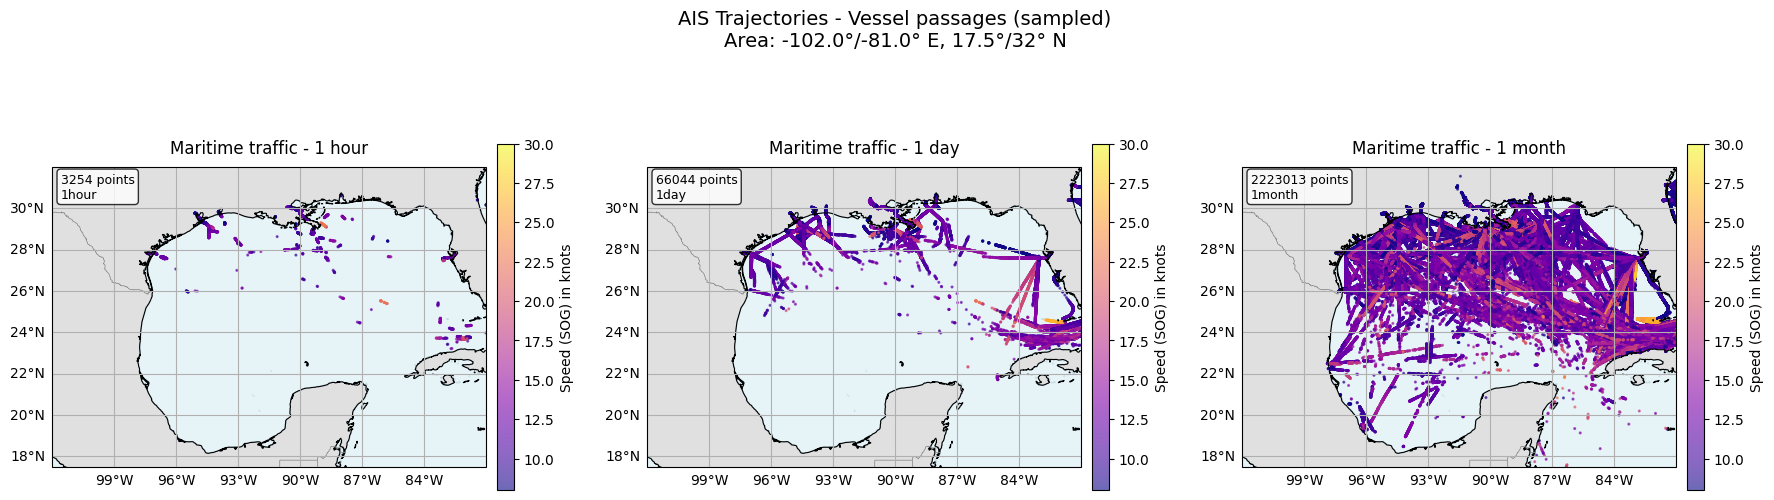


DETAILED STATISTICS (sampled data)

1HOUR:
  - Number of points: 3,254
  - Mean speed: 11.9 knots
  - Median speed: 11.8 knots
  - Time range: 2024-01-01 00:00:00 to 2024-01-01 01:00:00

1DAY:
  - Number of points: 66,044
  - Mean speed: 12.1 knots
  - Median speed: 11.8 knots
  - Time range: 2024-01-01 00:00:00 to 2024-01-02 00:00:00

1MONTH:
  - Number of points: 2,223,013
  - Mean speed: 12.2 knots
  - Median speed: 11.8 knots
  - Time range: 2024-01-01 00:00:00 to 2024-01-31 00:00:00

Memory optimization:
- Reading by chunks of 50,000 lines (using pyarrow row groups)
- Sampling: max 2,320,371/1hour, 2,320,371/1day, 2,320,371/1month
- Loaded columns: ['BaseDateTime', 'LON', 'LAT', 'SOG']


In [ ]:
# ============================================
# Filtered AIS Sampled map with stats - AIS Deep Learning Project
# ============================================

sampled_maps(merged_path, LON_MIN, LON_MAX, LAT_MIN, LAT_MAX, SOG_MIN, SOG_MAX, sampling_norm=False)


Analyse de 2320371 observations
--------------------------------------------------

STATISTIQUES DÉTAILLÉES:
------------------------------
Number of observations: 2320371.0000
Mean (deg): 2.43
Median (deg): 1.60
Standard deviation (deg): 3.16
Min (deg): 0.00
Max (deg): 180.00
Q1 (deg): 0.70
Q3 (deg): 3.10
IQR (deg): 2.40
ADVANCED STATISTICAL ANALYSIS

Normality test (Shapiro-Wilk if n<5000, D'Agostino otherwise):
N before: 2320371 | N after: 2320371
Test: D’Agostino K² | stat=67751.568 | p-value=0

Circular statistics:
Mean direction: 2.43°
Circular variance: 0.0030
Concentration: 0.9970

Percentiles (degrees):
P5: 0.10°
P10: 0.30°
P25: 0.70°
P50: 1.60°
P75: 3.10°
P90: 5.40°
P95: 7.30°


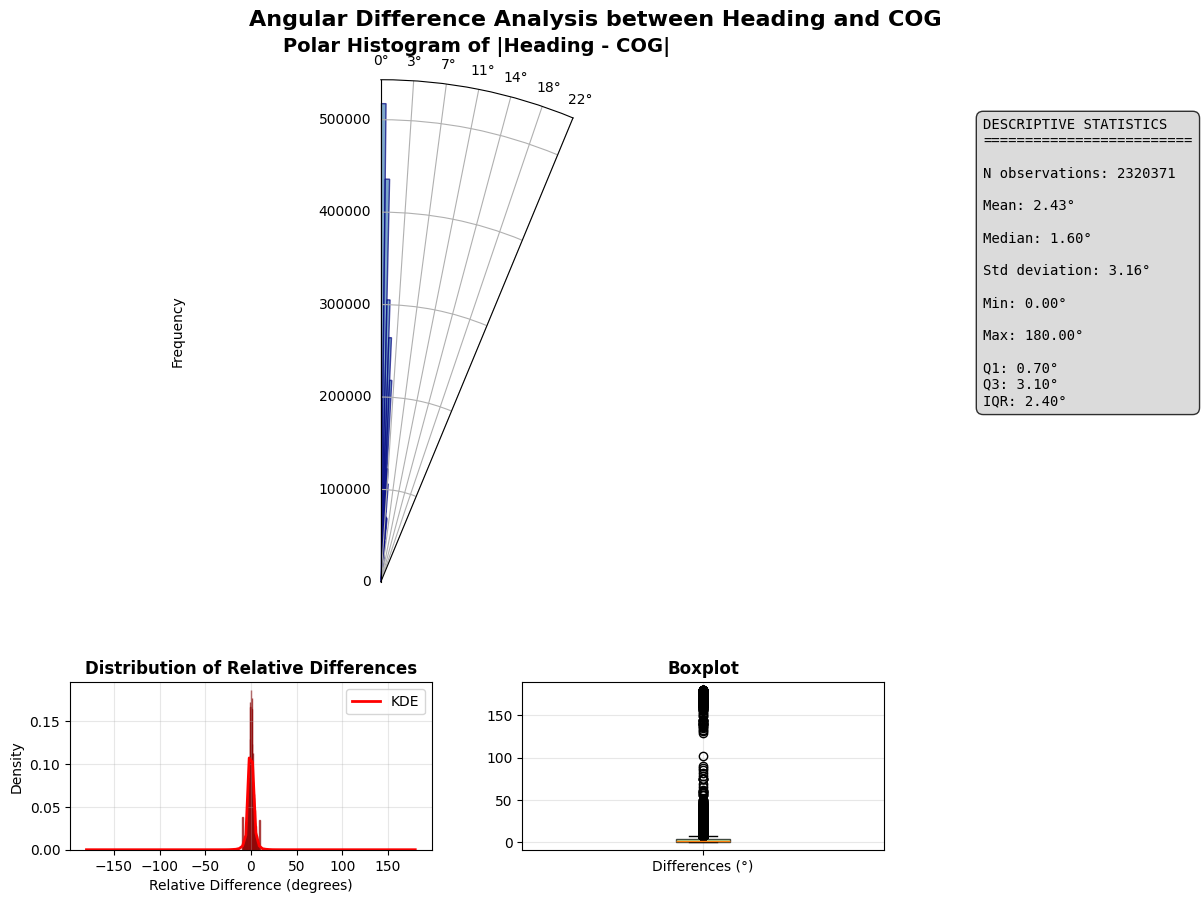

In [ ]:
# ============================================
# Drift Stats - AIS Deep Learning Project
# ============================================

df_merged = pd.read_parquet(merged_path)

print(f"Analyse de {len(df_merged)} observations")
print("-" * 50)

# Création du graphique
fig, stats_dict = polar_histogram_with_stats(df_merged, bins=36)

# Affichage des statistiques détaillées
print("\nSTATISTIQUES DÉTAILLÉES:")
print("-" * 30)
for key, value in stats_dict.items():
    if isinstance(value, (int, float)):
        if 'deg' in key:
            print(f"{key}: {value:.2f}")
        else:
            print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Analyse avancée
advanced_polar_analysis(df_merged)
plt.show()

The analysis of the angular difference between the ship’s true heading **(Heading)** and its course over ground **(COG)** shows a distribution highly concentrated around zero.

Descriptive statistics indicate a mean of **2.43°** and a median of **1.60°**, confirming that in most cases the difference remains small. The dispersion is limited, with a standard deviation of **3.16°** and an interquartile range (IQR) from 0.70° to 3.10°.

The percentile analysis provides further detail:

- **P5: 0.10°**  
- **P10: 0.30°**  
- **P25: 0.70°**  
- **P50 (median): 1.60°**  
- **P75: 3.10°**  
- **P90: 5.40°**  
- **P95: 7.30°**

This means that **95% of the observations have a difference below 7.3°**, which confirms that Heading and COG are usually very close, with only a few extreme cases (up to 180°) visible in the boxplot.

In the next step of our data preprocessing, we will further clean the AIS dataset by **retaining only the messages where the absolute difference between Heading and COG is less than 8°**.  
Additionally, to focus on the study area, messages will be **spatially filtered inside an ellipse centered over the Gulf of Mexico**.  

This dual filtering will ensure a cleaner and more representative dataset for analyzing ocean currents from AIS trajectories.


In [ ]:
# ============================================
# Create Filtered Dataset for ML - AIS Deep Learning Project
# ============================================

create_merged_dataset(
    merged_path,
    MERCATOR_FILE,
    dataset_path,
    lon_c=-90, # Ellipse center
    lat_c=25, # Ellipse center
    a_lon=6.0, # half-ax for longitude
    b_lat=3.0, # half-ax for latitude
    )

In [ ]:
# ============================================
# Check Dataset for ML - AIS Deep Learning Project
# ============================================

df_dataset = pd.read_parquet(dataset_path)

print("\n--- DATASET Ready ---")
print("Total rows   :", len(df_dataset))
display(df_dataset.describe())


--- DATASET Ready ---
Total rows   : 121583


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselType,Length,Width,Draft,Cargo,Drift,U,V,PHI
count,1.215830e+05,121583,121583.000000,121583.000000,121583.000000,121583.000000,121583.000000,121583.000000,121583.000000,121583.000000,121583.000000,121583.000000,121583.000000,121583.000000,121583.000000,121583.000000
mean,4.278100e+08,2024-01-17 07:39:02.378449152,26.388565,-89.595886,12.993332,205.043399,204.747300,74.211395,209.444758,33.329750,9.077605,74.192387,-0.041458,0.111913,-0.032084,165.696960
min,2.056810e+08,2024-01-01 00:00:05,22.007530,-95.998850,8.000000,0.000000,0.000000,60.000000,45.000000,9.000000,2.200000,0.000000,-8.000000,-1.319809,-1.883202,0.032349
25%,3.110036e+08,2024-01-08 04:51:35,25.380675,-92.152030,11.300000,117.600000,117.000000,70.000000,182.000000,30.000000,7.500000,70.000000,-2.100000,-0.114800,-0.208866,82.966461
50%,3.719620e+08,2024-01-15 03:03:52,26.723000,-89.451530,12.700000,184.500000,184.000000,71.000000,199.000000,32.000000,8.600000,71.000000,0.000000,0.073410,-0.005332,146.942078
75%,5.380100e+08,2024-01-26 03:08:15,27.497240,-87.516845,14.400000,312.000000,311.000000,80.000000,230.000000,36.000000,11.000000,80.000000,2.100000,0.280749,0.170489,249.966644
max,6.421220e+08,2024-01-31 23:59:58,27.999400,-84.000570,23.300000,359.900000,359.000000,80.000000,345.000000,52.000000,16.200000,168.000000,8.000000,1.645436,1.605268,359.998108
std,1.390922e+08,NaN,1.257976,2.969517,2.552834,108.647045,108.982927,5.787977,54.214086,7.452754,2.353393,6.909277,3.250716,0.353284,0.356382,102.027100


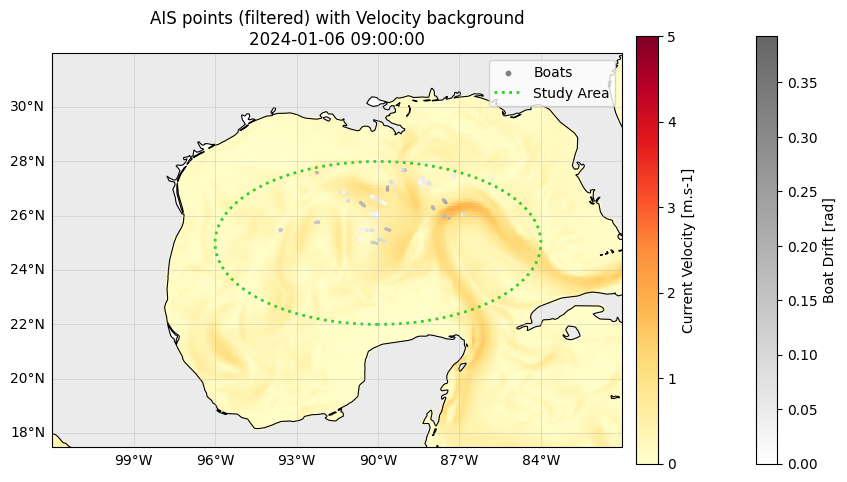

In [ ]:
# ============================================
# Merged AIS / Ship within Study Area (1-Hour Window at tboat) - AIS Deep Learning Project
# ============================================

plot_merged_ais_ship(
    dataset_path,
    MERCATOR_FILE,
    lon_c=-90, # Ellipse center
    lat_c=25, # Ellipse center
    a_lon=6.0, # half-ax for longitude
    b_lat=3.0, # half-ax for latitude
    tboat=pd.to_datetime('2024-01-06 09:00'), # Time with many boats
    LON_MIN=LON_MIN,
    LON_MAX=LON_MAX,
    LAT_MIN=LAT_MIN,
    LAT_MAX=LAT_MAX
)

Analyse de 121583 observations
--------------------------------------------------

STATISTIQUES DÉTAILLÉES:
------------------------------
Number of observations: 121583.0000
Mean (deg): 2.59
Median (deg): 2.10
Standard deviation (deg): 1.96
Min (deg): 0.00
Max (deg): 8.00
Q1 (deg): 1.00
Q3 (deg): 3.80
IQR (deg): 2.80
ADVANCED STATISTICAL ANALYSIS

Normality test (Shapiro-Wilk if n<5000, D'Agostino otherwise):
N before: 121583 | N after: 121583
Test: D’Agostino K² | stat=549.723 | p-value=4.26e-120

Circular statistics:
Mean direction: 2.59°
Circular variance: 0.0012
Concentration: 0.9988

Percentiles (degrees):
P5: 0.20°
P10: 0.40°
P25: 1.00°
P50: 2.10°
P75: 3.80°
P90: 5.60°
P95: 6.60°


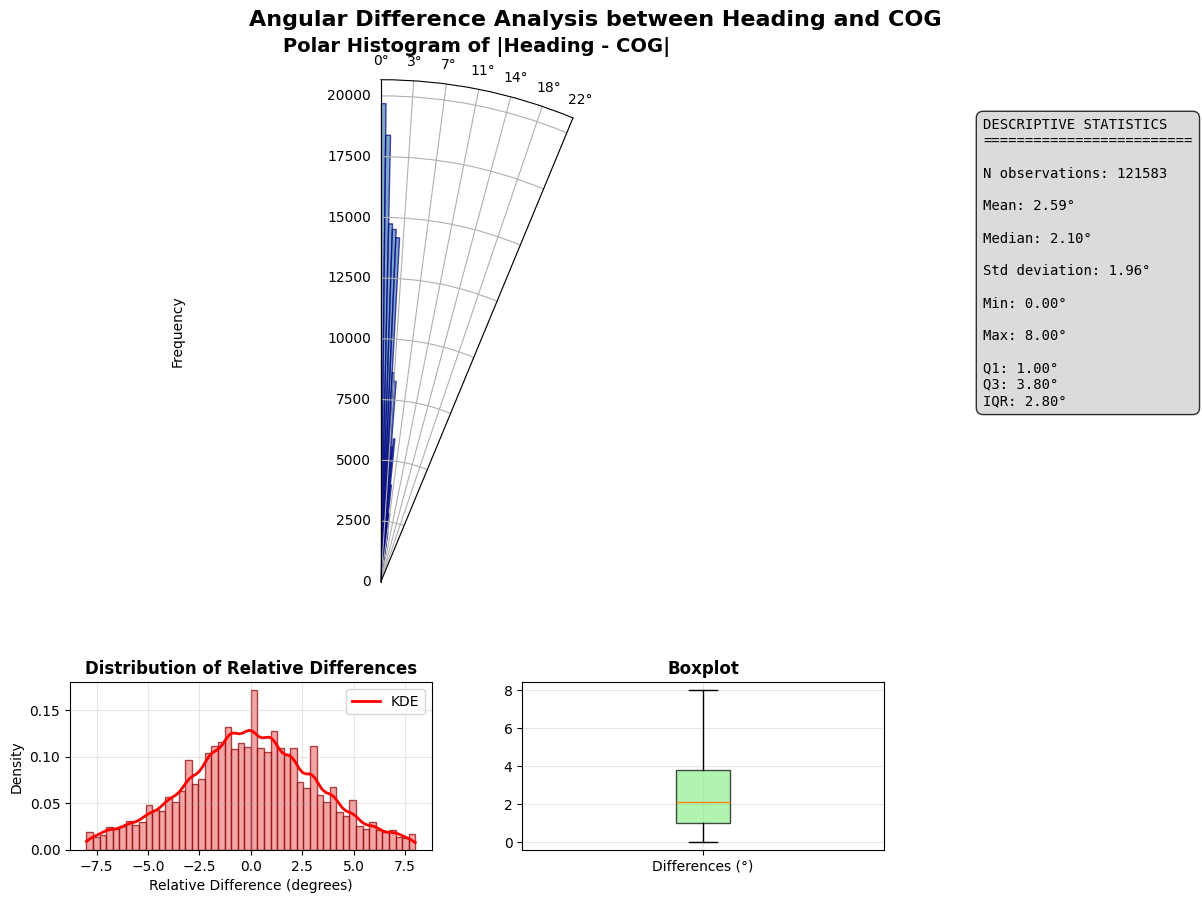

In [ ]:
# ============================================
# Dataset for ML Drift Stats - AIS Deep Learning Project
# ============================================

df_dataset = pd.read_parquet(dataset_path)

print(f"Analyse de {len(df_dataset)} observations")
print("-" * 50)

# Création du graphique
fig, stats_dict = polar_histogram_with_stats(df_dataset, bins=36)

# Affichage des statistiques détaillées
print("\nSTATISTIQUES DÉTAILLÉES:")
print("-" * 30)
for key, value in stats_dict.items():
    if isinstance(value, (int, float)):
        if 'deg' in key:
            print(f"{key}: {value:.2f}")
        else:
            print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Analyse avancée
advanced_polar_analysis(df_dataset)
plt.show()

The major reduction in the number of data points is primarily due to the geographical filtering, which selects only AIS messages within the study area. On top of that, restricting angular differences removes extreme cases and outliers. These outliers, although rare, can significantly distort the training process of machine learning models by introducing noise that does not reflect the typical vessel dynamics.

# Animation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML, Video
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import timedelta
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 500  # en MB

loaded_mercator = xr.open_dataset(MERCATOR_FILE)
LON_m = loaded_mercator['longitude'].values
LAT_m = loaded_mercator['latitude'].values

df = pd.read_parquet(dataset_path)

# --- Paramètres d'animation ---
# Utilise l'intégralité de la dimension temporelle du NetCDF ; tu peux restreindre avec START/END si besoin
times = pd.to_datetime(loaded_mercator['time'].values)  # index temporel du NetCDF
# Optionnel : restreindre
# START = pd.Timestamp('2024-01-01 00:00')
# END   = pd.Timestamp('2024-01-01 23:00')
# times = times[(times >= START) & (times <= END)]

fps = 15                 # images/seconde pour la vidéo
interval_ms = 100        # intervalle d'affichage (ms) dans le notebook
bitrate = 2000           # bitrate du MP4
outfile = "/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/results/mercator_anim.mp4"

# --- Préparation figure/axes ---
fig, axes = plt.subplots(
    2, 1, figsize=(12, 10),
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=False
)
fig.subplots_adjust(top=0.90)

def style_map(ax):
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)

cm_mesh = 'Spectral' #'YlOrRd'
vmin_mesh, vmax_mesh = -2, 2

# Création des QuadMesh initiaux (avec la 1ère date)
t0 = times[0]
ds0 = loaded_mercator.sel(time=t0)
fields0 = [
    (ds0["uo"].values[0], "U - Mercator"),
    (ds0["vo"].values[0], "V - Mercator")
]

quadmeshes = []
for ax, (data, title) in zip(axes, fields0):
    im = ax.pcolormesh(
        LON_m, LAT_m, data,
        shading='auto', cmap=cm_mesh, vmin=vmin_mesh, vmax=vmax_mesh
    )
    ax.set_title(title)
    style_map(ax)
    quadmeshes.append(im)

# Scatter initial (éventuellement vide)
scatter_list = []
for ax in axes:
    # On met un scatter "vide" pour pouvoir mettre à jour ensuite
    sc = ax.scatter([], [], c=[], cmap='binary', s=1.5, alpha=0.6,
                    vmin=0, vmax=8, transform=ccrs.PlateCarree())
    scatter_list.append(sc)

# Colorbars
cbar_mesh = fig.colorbar(quadmeshes[0], ax=axes, label='[m.s-1]')
cbar_sc   = fig.colorbar(scatter_list[0], ax=axes, shrink=0.7, pad=0.02)
cbar_sc.set_label('|Drift| [°]', fontsize=10)

# Suptitle avec espace
suptitle = fig.suptitle(f"Time - {t0}", y=0.98)  # y<1.0 pour éviter le clipping
fig.canvas.draw_idle()  # force un premier draw du titre

# --- Fonctions utilitaires ---
def select_points_for_hour(t):
    """Sélectionne les points AIS pour l'heure [t, t+1h]."""
    t_next = t + pd.Timedelta(hours=1)
    sub = df[(df["BaseDateTime"] >= t) & (df["BaseDateTime"] < t_next)]
    return sub

def update(frame_idx):
    t = times[frame_idx]

    # 1) Mettre à jour les champs U/V
    ds = loaded_mercator.sel(time=t)
    new_U = ds["uo"].values[0]
    new_V = ds["vo"].values[0]

    # pcolormesh -> set_array attend un tableau ravel() (mêmes dimensions de maillage)
    quadmeshes[0].set_array(new_U.ravel())
    quadmeshes[1].set_array(new_V.ravel())

    # 2) Mettre à jour le scatter
    sub = select_points_for_hour(t)
    if len(sub) > 0:
        xy = np.column_stack([sub['LON'].values, sub['LAT'].values])
        for sc in scatter_list:
            sc.set_offsets(xy)
            sc.set_array(np.abs(sub['Drift'].values))  # met à jour la colormap
            sc.set_sizes(np.full(len(sub), 1.5))
            sc.set_alpha(0.6)
    else:
        # pas de points pour cette heure -> on vide
        for sc in scatter_list:
            sc.set_offsets(np.empty((0, 2)))
            sc.set_array(np.array([]))

    # 3) Suptitle
    suptitle.set_text(f"Time - {pd.to_datetime(t).strftime('%Y-%m-%d %H:00')}")
    fig.canvas.draw_idle()  # force un premier draw du titre)
    #print(f"Time loaded : {pd.to_datetime(t).strftime('%Y-%m-%d %H:00')}")

    return quadmeshes + scatter_list + [suptitle]

# --- Création de l'animation ---
anim = FuncAnimation(
    fig, update, frames=len(times),
    interval=interval_ms, blit=False
)

plt.close(fig)  # évite l’affichage du canvas statique sous Colab

# --- Affichage HTML5 dans le notebook ---
display(HTML(anim.to_jshtml()))  # Option légère; sinon anim.to_html5_video()

# --- Export MP4 ---
writer = FFMpegWriter(fps=fps, bitrate=bitrate)
anim.save(outfile, writer=writer)
print(f"Vidéo enregistrée -> {outfile}")

# --- Afficher la vidéo MP4 en HTML5 ---
display(Video(outfile, embed=True))

# --- Proposer le téléchargement ---
try:
    from google.colab import files
    files.download(outfile)
except Exception as e:
    print("Téléchargement Colab indisponible ici. Récupère le fichier à l’emplacement indiqué.")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML, Video
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import timedelta
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 500  # en MB

loaded_mercator = xr.open_dataset(MERCATOR_FILE)
LON_m = loaded_mercator['longitude'].values
LAT_m = loaded_mercator['latitude'].values

df = pd.read_parquet(dataset_path)

# --- Paramètres d'animation ---
# Utilise l'intégralité de la dimension temporelle du NetCDF ; tu peux restreindre avec START/END si besoin
times = pd.to_datetime(loaded_mercator['time'].values)  # index temporel du NetCDF
# Optionnel : restreindre
# START = pd.Timestamp('2024-01-01 00:00')
# END   = pd.Timestamp('2024-01-01 23:00')
# times = times[(times >= START) & (times <= END)]

fps = 15                 # images/seconde pour la vidéo
interval_ms = 100        # intervalle d'affichage (ms) dans le notebook
bitrate = 2000           # bitrate du MP4
outfile = "/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/results/mercator_anim_velocity.mp4"

# --- Préparation figure/axes ---
fig, ax = plt.subplots(
    1, 1, figsize=(12, 10),
    subplot_kw={'projection': ccrs.PlateCarree()},
    constrained_layout=False
)
fig.subplots_adjust(top=0.90)

def style_map(ax):
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)

cm_mesh = 'YlOrRd'
vmin_mesh, vmax_mesh = 0, 5

# --- Création des QuadMesh initiaux (avec la 1ère date)
t0 = times[0]
ds0 = loaded_mercator.sel(time=t0)

velocity0 = np.sqrt(ds0["uo"].values[0]**2 + ds0["vo"].values[0]**2)

quadmeshes = []
im = ax.pcolormesh(
    LON_m, LAT_m, velocity0,
    shading='auto', cmap=cm_mesh, vmin=vmin_mesh, vmax=vmax_mesh
)
ax.set_title(title)  # <- assure-toi que `title` est défini quelque part
style_map(ax)
quadmeshes.append(im)

# Scatter initial (éventuellement vide)
scatter_list = []
# On met un scatter "vide" pour pouvoir mettre à jour ensuite
sc = ax.scatter([], [], c=[], cmap='binary', s=1.5, alpha=0.6,
                    vmin=0, vmax=8, transform=ccrs.PlateCarree())
scatter_list.append(sc)

# Colorbars
cbar_mesh = fig.colorbar(quadmeshes[0], ax=ax, label='[m.s-1]')
cbar_sc   = fig.colorbar(scatter_list[0], ax=ax, shrink=0.7, pad=0.02)
cbar_sc.set_label('|Drift| [°]', fontsize=10)

# Suptitle avec espace
suptitle = fig.suptitle(f"Time - {t0}", y=0.98)  # y<1.0 pour éviter le clipping
fig.canvas.draw_idle()  # force un premier draw du titre

# --- Fonctions utilitaires ---
def select_points_for_hour(t):
    """Sélectionne les points AIS pour l'heure [t, t+1h]."""
    t_next = t + pd.Timedelta(hours=1)
    sub = df[(df["BaseDateTime"] >= t) & (df["BaseDateTime"] < t_next)]
    return sub

def update(frame_idx):
    t = times[frame_idx]

    # 1) Mettre à jour la VITESSE (norme)
    ds = loaded_mercator.sel(time=t)
    U = ds["uo"].values[0]
    V = ds["vo"].values[0]
    speed = np.sqrt(U**2 + V**2)

    # pcolormesh -> set_array attend un tableau ravel() (mêmes dimensions de maillage)
    quadmeshes[0].set_array(speed.ravel())
    # Si jamais tu as un message de mismatch de dimensions,
    # remplace par: quadmeshes[0].set_array(speed[:-1, :-1].ravel())
    # 2) Mettre à jour le scatter
    sub = select_points_for_hour(t)
    if len(sub) > 0:
        xy = np.column_stack([sub['LON'].values, sub['LAT'].values])
        sc = scatter_list[0]
        sc.set_offsets(xy)
        sc.set_array(np.abs(sub['Drift'].values))
        sc.set_sizes(np.full(len(sub), 1.5))
        sc.set_alpha(0.6)
    else:
        sc = scatter_list[0]
        sc.set_offsets(np.empty((0, 2)))
        sc.set_array(np.array([]))

    # 3) Suptitle
    suptitle.set_text(f"Time - {pd.to_datetime(t).strftime('%Y-%m-%d %H:00')}")
    fig.canvas.draw_idle()
    #print(f"Time loaded : {pd.to_datetime(t).strftime('%Y-%m-%d %H:00')}")

    return [quadmeshes[0], scatter_list[0], suptitle]

# --- Création de l'animation ---
anim = FuncAnimation(
    fig, update, frames=len(times),
    interval=interval_ms, blit=False
)

plt.close(fig)  # évite l’affichage du canvas statique sous Colab

# --- Affichage HTML5 dans le notebook ---
display(HTML(anim.to_jshtml()))  # Option légère; sinon anim.to_html5_video()

# --- Export MP4 ---
writer = FFMpegWriter(fps=fps, bitrate=bitrate)
anim.save(outfile, writer=writer)
print(f"Vidéo enregistrée -> {outfile}")

# --- Afficher la vidéo MP4 en HTML5 ---
display(Video(outfile, embed=True))

# --- Proposer le téléchargement ---
try:
    from google.colab import files
    files.download(outfile)
except Exception as e:
    print("Téléchargement Colab indisponible ici. Récupère le fichier à l’emplacement indiqué.")


Output hidden; open in https://colab.research.google.com to view.

# 3./ Machine Learning implementation

In [5]:
# Dependencies
#! pip install captum
#from captum.attr import LRP
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, Subset
import matplotlib.pyplot as plt
import sys
import os


sys.path.append(os.path.abspath("/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project"))
dataset_path = os.path.join(DST_DIR, f"DATASET_{MONTH_ABBR}_{YEAR}.parquet")

from models.ml_utils import generate_dataloader

path = "/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/models/MLP_classifier_410E_lr-3.pth"

sog_max = 25
sog_min = 8
c_max = 5
length_max = 400
width_max = 60
draft_max = 25

batch_size = 64

In [44]:
# ============================================
# Create TrainDataLoader / EvalDataset - AIS Deep Learning Project
# ============================================

train_loader, eval_dataset = generate_dataloader(dataset_path=dataset_path,
                        sog_max=sog_max,
                        sog_min= sog_min,
                        c_max=c_max,
                        length_max=length_max,
                        width_max=width_max,
                        draft_max=draft_max,
                        batch_size=batch_size,
                        unique_MMSI=True
                        )

MMSI tiré : 367633000 | Nombre de signaux : 1039
Heading Tensor Shape:  torch.Size([1039])
COG Tensor Shape:  torch.Size([1039])
SOG Tensor Shape:  torch.Size([1039])
U Tensor Shape:  torch.Size([1039])
V Tensor Shape:  torch.Size([1039])
Dataset lenght:  1039
Train Subset lenght:  779


In [45]:
train_dataset = train_loader.dataset

heading_train, cog_train, sog_train, length_train, width_train, draft_train, u_train, v_train = zip(*train_dataset)

heading_train = torch.stack(heading_train)
cog_train = torch.stack(cog_train)
sog_train = torch.stack(sog_train)
length_train = torch.stack(length_train)
width_train = torch.stack(width_train)
draft_train = torch.stack(draft_train)
u_train = torch.stack(u_train)
v_train = torch.stack(v_train)
velocity_train = torch.sqrt(u_train.pow(2) + v_train.pow(2))


In [7]:
import torch.nn as nn
import torch.nn.functional as F

def ang_diff(cog, heading):
    """Retourn wrap(cog - heading) in (-pi, pi]."""
    s = torch.sin(cog - heading)
    c = torch.cos(cog - heading)
    return torch.atan2(s, c)


def si_loss(Y: torch.Tensor, X: torch.Tensor) -> torch.Tensor:
    """
    SI = sum_i num_i / sum_i ||x_i||^2

    Règle pour num_i :
      - si (||y_i|| > ||x_i||) et (<y_i, x_i> > 0):
            y_modif_i = (2||x_i|| - ||y_i||) * (y_i / ||y_i||)
            num_i = <y_modif_i, x_i>
        (si 2||x|| - ||y|| < 0, le facteur négatif inverse la direction → pénalisation)
      - sinon:
            num_i = <y_i, x_i>
    """
    eps = torch.finfo(Y.dtype).eps

    # Bases
    dot = (Y * X).sum(dim=1)           # <y_i, x_i>
    ny  = torch.norm(Y, dim=1)         # ||y_i||
    nx  = torch.norm(X, dim=1)         # ||x_i||

    # Condition
    cond = (ny > nx) & (dot > 0)

    # y_unit = y / ||y||
    y_unit = Y / ny.clamp_min(eps).unsqueeze(1)

    # Norme signée: peut être négative → inverse la direction si nécessaire
    new_norm_signed = 2 * nx - ny

    # <y_modif_i, x_i> = (2||x|| - ||y||) * <y_unit, x_i>
    dot_yunit_x = (y_unit * X).sum(dim=1)
    num_mod = new_norm_signed * dot_yunit_x

    # Appliquer la règle
    num_i = torch.where(cond, num_mod, dot)

    # Assemblage
    num = num_i.sum()
    den = (nx**2).sum().clamp_min(torch.finfo(X.dtype).eps)
    return num / den


def corr_loss(x, y, eps=1e-8, mode='square'):
    # 1) aplatir + masquer les non-finies
    x = x.reshape(-1)
    y = y.reshape(-1)
    mask = torch.isfinite(x) & torch.isfinite(y)
    x = x[mask]; y = y[mask]

    # 2) si trop peu d'échantillons, renvoyer une loss neutre mais backprop-safe
    if x.numel() < 2:
        return (x.sum() * 0) + 1.0  # garde le graphe

    # 3) centrer puis utiliser cosine_similarity avec eps pour stabiliser
    x = x - x.mean()
    y = y - y.mean()
    r = F.cosine_similarity(x, y, dim=0, eps=eps)  # ≈ Pearson r

    # 4) votre objective: maximiser |r| ↔ minimiser 1 - r^2
    if mode == 'square':
        return 1 - r.pow(2)
    if mode == 'abs':
        return 1 - torch.abs(r)
    elif mode == 'r':
      return r


# STW Fider

In [46]:

class MLPtest(nn.Module):
  def __init__(self, in_dim=5, hidden1=16, hidden2=8, out_dim=2):
    super(MLPtest, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(in_dim, hidden1, bias=True),
        nn.ReLU(),
        nn.Linear(hidden1, hidden2, bias=True),
        nn.ReLU(),
        nn.Linear(hidden2, out_dim, bias=True)
    )
  def forward(self, x_heading, x_cog, x_sog):
    x = torch.stack([torch.sin(x_heading), torch.cos(x_heading),
                   torch.sin(x_cog), torch.cos(x_cog),
                   x_sog],
                  dim=1)
    x_out = self.layers(x)
    return torch.tanh(x_out)*c_max

class MLPExt(nn.Module):
    def __init__(self, in_dim=6, hidden1=128, hidden2=32, out_dim=2, c_max=c_max):
        super(MLPExt, self).__init__()
        self.c_max = c_max

        # 🔹 Paramètre apprenable STW
        self.x_stw_nn = nn.Parameter(torch.tensor(1.0))

        # 🔹 Architecture du réseau
        self.layers = nn.Sequential(
            nn.Linear(in_dim, hidden1, bias=True),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2, bias=True),
            nn.ReLU(),
            nn.Linear(hidden2, out_dim, bias=True)
        )

    def forward(self, x_heading, x_cog, x_sog):
        # Construction du vecteur d'entrée
        batch_size = x_heading.shape[0]
        x_stw_nn = self.x_stw_nn.expand(batch_size)

        x = torch.stack([
            torch.sin(x_cog),
            torch.cos(x_cog),
            x_sog,
            torch.sin(x_heading),
            torch.cos(x_heading),
            x_stw_nn
        ], dim=1)

        x_out = self.layers(x)
        return torch.tanh(x_out) * self.c_max


Device : cuda
MLPExt(
  (layers): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)


100%|██████████| 20/20 [00:01<00:00, 16.04it/s]


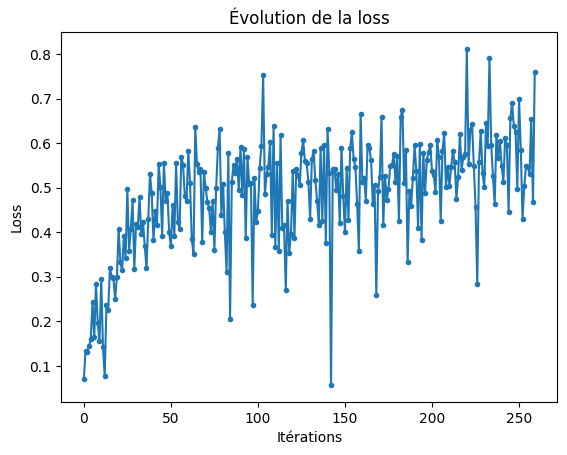

In [47]:
from tqdm import trange
import torch.optim as optim

# -- HyperParameters --
nb_epoch = 20
learning_rate = 1e-4
train_path = "/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/models/.pth"

# Détection du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")

# Instanciation du modèle
model = MLPExt().to(device)
#model.load_state_dict(torch.load(train_path, map_location=device))
print(model)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=[0.9, 0.99], maximize=True)

train_losses = []

for epoch in trange(nb_epoch):
    for i, (heading, cog, sog, _, _, _, u, v) in enumerate(train_loader):
        # Déplacement des données sur GPU
        heading = heading.to(device)
        cog = cog.to(device)
        sog = sog.to(device)
        u = u.to(device)
        v = v.to(device)

        # Forward pass
        out = model(x_heading=heading,
                    x_cog=cog,
                    x_sog=sog).squeeze(-1)

        label = torch.cat([u.unsqueeze(1), v.unsqueeze(1)], dim=1)
        loss = si_loss(out, label)

        train_losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()


plt.plot(train_losses, marker='.')
plt.title("Évolution de la loss")
plt.xlabel("Itérations")
plt.ylabel("Loss")
plt.show()

---SI---
0.32480812072753906
--- Network Output ---
Mean: 0.7449589371681213
Median: 0.7210622429847717
Std: 0.12247287482023239
Min: 0.43520399928092957
Max: 1.0540426969528198
--- Correct Value ---
Mean: 0.5138116478919983
Median: 0.3470236659049988
Std: 0.4259263873100281
Min: 0.08406883478164673
Max: 1.650120735168457


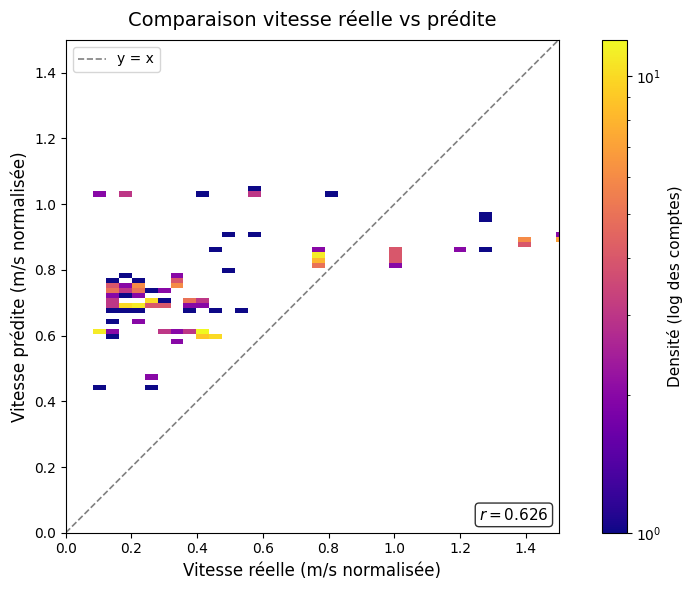

In [48]:
from matplotlib import colors

#model.load_state_dict(torch.load("modelFSA_subset_100e.pth"))
model.eval().cpu()

heading_eval, cog_eval, sog_eval, length_eval, width_eval, draft_eval, u_eval, v_eval = zip(*eval_dataset)

heading_eval = torch.stack(heading_eval)
cog_eval = torch.stack(cog_eval)
sog_eval = torch.stack(sog_eval)
length_eval = torch.stack(length_eval)
width_eval = torch.stack(width_eval)
draft_eval = torch.stack(draft_eval)
u_eval = torch.stack(u_eval)
v_eval = torch.stack(v_eval)
velocity_eval = torch.sqrt(u_eval.pow(2) + v_eval.pow(2))

with torch.no_grad():
    out_eval_nn = model(x_heading=heading_eval,
                        x_cog=cog_eval,
                        x_sog=sog_eval).squeeze(1)

    velocity_eval_nn = torch.sqrt(out_eval_nn[:,0].pow(2) + out_eval_nn[:,1].pow(2))

    label_eval = torch.cat([u_eval.unsqueeze(1), v_eval.unsqueeze(1)], dim=1)
    si = si_loss(out_eval_nn, label_eval).item()
    r = corr_loss(velocity_eval, velocity_eval_nn, mode='r')


print("---SI---")
print(si)
print("--- Network Output ---")
print("Mean:", velocity_eval_nn.mean().item())
print("Median:", velocity_eval_nn.median().item())
print("Std:", velocity_eval_nn.std().item())
print("Min:", velocity_eval_nn.min().item())
print("Max:", velocity_eval_nn.max().item())

print("--- Correct Value ---")
print("Mean:", velocity_eval.mean().item())
print("Median:", velocity_eval.median().item())
print("Std:", velocity_eval.std().item())
print("Min:", velocity_eval.min().item())
print("Max:", velocity_eval.max().item())

# Figure et axe
fig, ax = plt.subplots(figsize=(9, 6))
norm = colors.LogNorm()

# Histogramme 2D (densité)
h = ax.hist2d(
    velocity_eval.detach(),
    velocity_eval_nn.detach(),
    bins=40,
    cmap='plasma',
    norm=norm
)

# Barre de couleur (log)
cbar = fig.colorbar(h[3], ax=ax)
cbar.set_label("Densité (log des comptes)", fontsize=11)

# Ligne diagonale y = x
ax.plot([0, 1.5], [0, 1.5], linestyle="--", color="gray", linewidth=1.2, label="y = x")

# Texte du coefficient de corrélation
ax.text(
    0.98, 0.02,
    f"$r = {r:.3f}$",
    transform=ax.transAxes,
    ha="right", va="bottom",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8)
)

# Limites et étiquettes
ax.set_xlim(0, 1.5)
ax.set_ylim(0, 1.5)
ax.set_xlabel("Vitesse réelle (m/s normalisée)", fontsize=12)
ax.set_ylabel("Vitesse prédite (m/s normalisée)", fontsize=12)
ax.set_title("Comparaison vitesse réelle vs prédite", fontsize=14, pad=10)

# Aspect carré et légende
ax.set_aspect('equal', 'box')
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

In [49]:
# Afficher le paramètre x_stw_nn
print("x_stw_nn =", model.x_stw_nn)

# Pour n’afficher que sa valeur (sans le wrapper Parameter)
print("Valeur numérique :", model.x_stw_nn.item())

x_stw_nn = Parameter containing:
tensor(0.9958, requires_grad=True)
Valeur numérique : 0.995768666267395


In [ ]:
save_path = f"/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/models/dict_{nb_epoch}E_lr{learning_rate}.pth"

save_dict = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
}
torch.save(save_dict, save_path)

# All AIS

In [24]:
class SABlock(nn.Module):
    def __init__(self, d_model=64, n_heads=8, dropout=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(d_model, n_heads, batch_first=True, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(4*d_model, d_model),
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, return_attn=False):
        attn_out, attn = self.mha(x, x, x, need_weights=True, average_attn_weights=False)
        x = self.norm1(x + self.drop(attn_out))
        f = self.ffn(x)
        x = self.norm2(x + self.drop(f))
        if return_attn:
            # attn: [batch, n_heads, F, F]
            return x, attn
        return x, None

class FeatureSelfAttention(nn.Module):
    """
    Auto-attention entre N features scalaires.
    - On projette chaque scalaire -> vecteur (projection partagée)
    - On ajoute une 'embedding d'identité' par feature (apprend qui est qui)
    - On passe plusieurs blocs d'auto-attention
    - On pool (moyenne) et on prédit
    """
    def __init__(self, n_features=10, d_model=64, n_heads=8, n_layers=2, out_dim=2, dropout=0.1, c_max=c_max):
        super().__init__()
        self.n_features = n_features
        self.scalar2vec = nn.Linear(1, d_model)                # projection partagée 1->d
        self.feature_id = nn.Parameter(torch.randn(n_features, d_model))  # embedding par feature
        self.blocks = nn.ModuleList([SABlock(d_model, n_heads, dropout) for _ in range(n_layers)])
        self.head = nn.Linear(d_model, out_dim)                 # tête de sortie (régression)
        self.c_max = c_max

    def forward(self, x_heading, x_cog, x_sog, x_length, x_width, x_draft, return_attn=False):
        x_dch = ang_diff(x_cog, x_heading)
        x_trig = torch.stack([torch.sin(x_heading), torch.cos(x_heading),
                              torch.sin(x_cog), torch.cos(x_cog),
                              torch.sin(x_dch), torch.cos(x_dch),
                              x_sog,
                              x_length, x_width, x_draft],
                             dim=1)

        B, F = x_trig.shape
        assert F == self.n_features, f"Attendu {self.n_features} features, reçu {F}"
        # 1) projeter scalaires -> vecteurs
        h = self.scalar2vec(x_trig.unsqueeze(-1))                    # [B, F, d_model]
        # 2) ajouter l'identité de feature
        h = h + self.feature_id.unsqueeze(0)                    # [B, F, d_model]
        # 3) blocs d'auto-attention
        attn_list = []
        for blk in self.blocks:
            h, attn = blk(h, return_attn)
            if return_attn and attn is not None:
                attn_list.append(attn)                          # [B, n_heads, F, F]
        # 4) pooling (moyenne sur les features) puis prédiction
        z = h.mean(dim=1)                                       # [B, d_model]
        y = self.head(z)
        out = torch.tanh(y) * self.c_max                                        # [B, out_dim]
        if return_attn:
            return out, attn_list
        return out

Device : cuda
FeatureSelfAttention(
  (scalar2vec): Linear(in_features=1, out_features=64, bias=True)
  (blocks): ModuleList(
    (0-1): 2 x SABlock(
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=256, out_features=64, bias=True)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0.1, inplace=False)
    )
  )
  (head): Linear(in_features=64, out_features=2, bias=True)
)


100%|██████████| 10/10 [02:09<00:00, 12.97s/it]


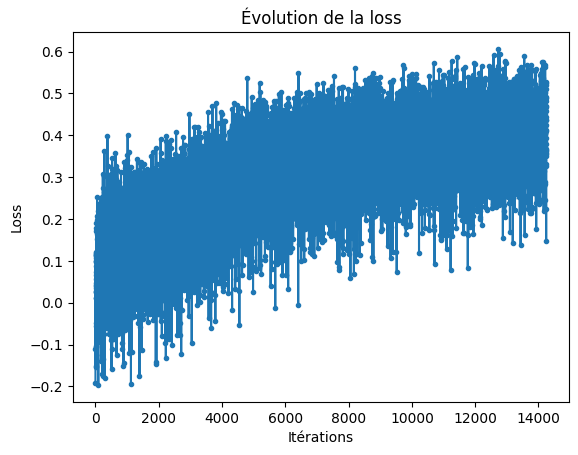

In [27]:
from tqdm import trange
import torch.optim as optim

# -- HyperParameters --
nb_epoch = 10
learning_rate = 1e-4
train_path = "/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/models/.pth"

# Détection du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")

# Instanciation du modèle
model = FeatureSelfAttention().to(device)
#model.load_state_dict(torch.load(train_path, map_location=device))
print(model)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=[0.7, 0.99], maximize=True)

train_losses = []

for epoch in trange(nb_epoch):
    for i, (heading, cog, sog, length, width, draft, u, v) in enumerate(train_loader):
        # Déplacement des données sur GPU
        heading = heading.to(device)
        cog = cog.to(device)
        sog = sog.to(device)
        length = length.to(device)
        width = width.to(device)
        draft = draft.to(device)
        u = u.to(device)
        v = v.to(device)

        # Forward pass
        out = model(x_heading=heading,
                    x_cog=cog,
                    x_sog=sog,
                    x_length=length,
                    x_width=width,
                    x_draft=draft).squeeze(-1)

        label = torch.cat([u.unsqueeze(1), v.unsqueeze(1)], dim=1)
        loss = si_loss(out, label)

        train_losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()


plt.plot(train_losses, marker='.')
plt.title("Évolution de la loss")
plt.xlabel("Itérations")
plt.ylabel("Loss")
plt.show()

---SI---
0.25977185368537903
--- Network Output ---
Mean: 0.490422785282135
Median: 0.4674491286277771
Std: 0.23826271295547485
Min: 0.004440090153366327
Max: 1.5102547407150269
--- Correct Value ---
Mean: 0.3656472861766815
Median: 0.2965840995311737
Std: 0.2731025815010071
Min: 0.003017173148691654
Max: 1.6189693212509155


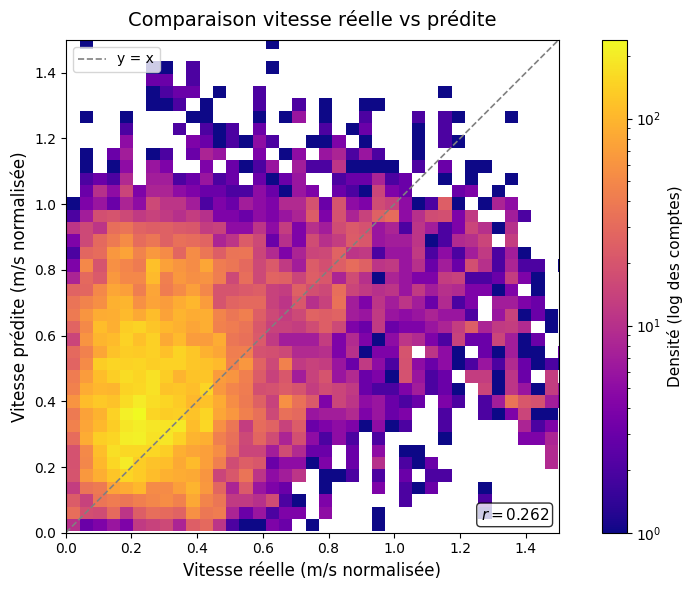

In [28]:
from matplotlib import colors

#model.load_state_dict(torch.load("modelFSA_subset_100e.pth"))
model.eval().cpu()

heading_eval, cog_eval, sog_eval, length_eval, width_eval, draft_eval, u_eval, v_eval = zip(*eval_dataset)

heading_eval = torch.stack(heading_eval)
cog_eval = torch.stack(cog_eval)
sog_eval = torch.stack(sog_eval)
length_eval = torch.stack(length_eval)
width_eval = torch.stack(width_eval)
draft_eval = torch.stack(draft_eval)
u_eval = torch.stack(u_eval)
v_eval = torch.stack(v_eval)
velocity_eval = torch.sqrt(u_eval.pow(2) + v_eval.pow(2))

with torch.no_grad():
    out_eval_nn = model(x_heading=heading_eval,
                        x_cog=cog_eval,
                        x_sog=sog_eval,
                        x_length=length_eval,
                        x_width=width_eval,
                        x_draft=draft_eval
                        ).squeeze(1)

    velocity_eval_nn = torch.sqrt(out_eval_nn[:,0].pow(2) + out_eval_nn[:,1].pow(2))

    label_eval = torch.cat([u_eval.unsqueeze(1), v_eval.unsqueeze(1)], dim=1)
    si = si_loss(out_eval_nn, label_eval).item()
    r = corr_loss(velocity_eval, velocity_eval_nn, mode='r')


print("---SI---")
print(si)
print("--- Network Output ---")
print("Mean:", velocity_eval_nn.mean().item())
print("Median:", velocity_eval_nn.median().item())
print("Std:", velocity_eval_nn.std().item())
print("Min:", velocity_eval_nn.min().item())
print("Max:", velocity_eval_nn.max().item())

print("--- Correct Value ---")
print("Mean:", velocity_eval.mean().item())
print("Median:", velocity_eval.median().item())
print("Std:", velocity_eval.std().item())
print("Min:", velocity_eval.min().item())
print("Max:", velocity_eval.max().item())

# Figure et axe
fig, ax = plt.subplots(figsize=(9, 6))
norm = colors.LogNorm()

# Histogramme 2D (densité)
h = ax.hist2d(
    velocity_eval.detach(),
    velocity_eval_nn.detach(),
    bins=40,
    cmap='plasma',
    norm=norm
)

# Barre de couleur (log)
cbar = fig.colorbar(h[3], ax=ax)
cbar.set_label("Densité (log des comptes)", fontsize=11)

# Ligne diagonale y = x
ax.plot([0, 1.5], [0, 1.5], linestyle="--", color="gray", linewidth=1.2, label="y = x")

# Texte du coefficient de corrélation
ax.text(
    0.98, 0.02,
    f"$r = {r:.3f}$",
    transform=ax.transAxes,
    ha="right", va="bottom",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8)
)

# Limites et étiquettes
ax.set_xlim(0, 1.5)
ax.set_ylim(0, 1.5)
ax.set_xlabel("Vitesse réelle (m/s normalisée)", fontsize=12)
ax.set_ylabel("Vitesse prédite (m/s normalisée)", fontsize=12)
ax.set_title("Comparaison vitesse réelle vs prédite", fontsize=14, pad=10)

# Aspect carré et légende
ax.set_aspect('equal', 'box')
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

# Classificator

### Justification for batch size = 64

We choose **batch size = 64** based on two simple rules for imbalanced datasets, where the positive rate is  
$p = 0.13$.

---

**1) Ensure enough positives per batch**

The expected number of positives in a batch is  
$E = p \cdot B$.

We aim for $E \in [8, 16]$ to ensure sufficient positive samples per gradient update.  

- For $E = 8$: $B \approx \tfrac{8}{0.13} \approx 62$.  
- For $E = 16$: $B \approx \tfrac{16}{0.13} \approx 123$.  

Thus, with $B = 64$, we obtain  
$E = 0.13 \times 64 \approx 8.3$ positives per batch, which is within the target range.

---

**2) Avoid all-negative batches**

The probability that a batch contains no positives is  
$P(\overline{positives}) = (1 - p)^B$.

- To keep $P(0) \leq 0.1\%$, we require $B \geq \tfrac{\ln(0.001)}{\ln(1 - p)} \approx 50$.  

With $B = 64$,  
$P(0) = (1 - 0.13)^{64} \approx 0.00013$


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


def ang_diff(cog, heading):
    """Retourn wrap(cog - heading) in (-pi, pi]."""
    s = torch.sin(cog - heading)
    c = torch.cos(cog - heading)
    return torch.atan2(s, c)

class MLP(nn.Module):
  def __init__(self, in_dim=10, out_dim=1):
    super(MLP, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(in_dim, 16),
        nn.ReLU(),
        nn.Linear(16, 8),
        nn.ReLU(),
        nn.Linear(8, out_dim)
    )
  def forward(self, x_lon, x_lat, x_heading, x_cog, x_sog, x_length, x_width, x_draft):
    x = torch.stack([x_lon, x_lat,
                   torch.sin(x_heading), torch.cos(x_heading),
                   torch.sin(x_cog), torch.cos(x_cog),
                   x_sog,
                   x_length,
                   x_width,
                   x_draft],
                  dim=1)
    x_out = self.layers(x)
    return x_out

class bigMLP(nn.Module):
  def __init__(self, in_dim=10, out_dim=1):
    super(bigMLP, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(in_dim, 160),
        nn.ReLU(),
        nn.Linear(160, 80),
        nn.ReLU(),
        nn.Linear(80, out_dim)
    )
  def forward(self, x_lon, x_lat, x_heading, x_cog, x_sog, x_length, x_width, x_draft):
    x = torch.stack([x_lon, x_lat,
                   torch.sin(x_heading), torch.cos(x_heading),
                   torch.sin(x_cog), torch.cos(x_cog),
                   x_sog,
                   x_length,
                   x_width,
                   x_draft],
                  dim=1)
    x_out = self.layers(x)
    return x_out

class SABlock(nn.Module):
    def __init__(self, d_model=64, n_heads=8, dropout=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(d_model, n_heads, batch_first=True, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(4*d_model, d_model),
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, return_attn=False):
        attn_out, attn = self.mha(x, x, x, need_weights=True, average_attn_weights=False)
        x = self.norm1(x + self.drop(attn_out))
        f = self.ffn(x)
        x = self.norm2(x + self.drop(f))
        if return_attn:
            # attn: [batch, n_heads, F, F]
            return x, attn
        return x, None

class FeatureSelfAttention(nn.Module):
    """
    Auto-attention entre N features scalaires.
    - On projette chaque scalaire -> vecteur (projection partagée)
    - On ajoute une 'embedding d'identité' par feature (apprend qui est qui)
    - On passe plusieurs blocs d'auto-attention
    - On pool (moyenne) et on prédit
    """
    def __init__(self, n_features=15, d_model=64, n_heads=8, n_layers=2, out_dim=1, dropout=0.1):
        super().__init__()
        self.n_features = n_features
        self.scalar2vec = nn.Linear(1, d_model)                # projection partagée 1->d
        self.feature_id = nn.Parameter(torch.randn(n_features, d_model))  # embedding par feature
        self.blocks = nn.ModuleList([SABlock(d_model, n_heads, dropout) for _ in range(n_layers)])
        self.head = nn.Linear(d_model, out_dim)                 # tête de sortie (régression/classe)

    def forward(self, x_lon, x_lat, x_heading, x_cog, x_sog, x_lenght, x_width, x_draft, return_attn=False):
        x_dch = ang_diff(x_cog, x_heading)
        x_trig = torch.stack([x_lon, x_lat,
                              torch.sin(x_heading), torch.cos(x_heading),
                              torch.sin(x_cog), torch.cos(x_cog),
                              torch.sin(x_dch), torch.cos(x_dch),
                              x_sog*torch.cos(x_dch),
                              x_sog*torch.sin(x_dch),
                              x_sog, x_sog**2,
                              x_lenght**2, x_width**2, x_draft**2],
                             dim=1)

        B, F = x_trig.shape
        assert F == self.n_features, f"Attendu {self.n_features} features, reçu {F}"
        # 1) projeter scalaires -> vecteurs
        h = self.scalar2vec(x_trig.unsqueeze(-1))                    # [B, F, d_model]
        # 2) ajouter l'identité de feature
        h = h + self.feature_id.unsqueeze(0)                    # [B, F, d_model]
        # 3) blocs d'auto-attention
        attn_list = []
        for blk in self.blocks:
            h, attn = blk(h, return_attn)
            if return_attn and attn is not None:
                attn_list.append(attn)                          # [B, n_heads, F, F]
        # 4) pooling (moyenne sur les features) puis prédiction
        z = h.mean(dim=1)                                       # [B, d_model]
        y = self.head(z)                                        # [B, out_dim]
        if return_attn:
            return y, attn_list
        return y

def f1_binary(
    preds: torch.Tensor,
    target: torch.Tensor,
    threshold: float = 0.5,
    from_logits: bool = True,
    epsilon: float = 1e-8,
):
    """
    Calcule le F1-score binaire entre preds et target.

    Args:
        preds: Tensor des prédictions du modèle.
               - Si from_logits=True : logits bruts (avant sigmoid), de forme (...,)
               - Si from_logits=False : probabilités dans [0,1], de forme (...,)
        target: Tensor des labels binaires {0,1}, même forme que preds.
        threshold: Seuil pour binariser les prédictions.
        from_logits: Si True, applique torch.sigmoid avant seuillage.
        epsilon: Petite constante pour éviter la division par zéro.

    Returns:
        f1: scalaire (tensor 0-dim) du F1-score.
        precision: précision binaire.
        recall: rappel binaire.
    """
    if from_logits:
        probs = torch.sigmoid(preds)
    else:
        probs = preds

    y_pred = (probs >= threshold).float()
    y_true = target

    tp = torch.sum(y_pred * y_true)
    fp = torch.sum(y_pred * (1 - y_true))
    fn = torch.sum((1 - y_pred) * y_true)

    print(tp, fp, fn)

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)

    return f1, precision, recall

class BinaryFocalLoss(torch.nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha  # pondération optionnelle entre classes
        self.reduction = reduction

    def forward(self, logits, targets):
        # Sigmoid → probas
        p = torch.sigmoid(logits)
        # p_t = p si y=1, sinon 1-p
        p_t = p * targets + (1 - p) * (1 - targets)
        # facteur focal
        focal_factor = (1 - p_t).pow(self.gamma)
        # log probas avec stabilité num.
        loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        loss = focal_factor * loss

        # pondération alpha (optionnelle)
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            loss = alpha_t * loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss



In [ ]:
from tqdm import trange
import torch.optim as optim

# -- HyperParameters --
nb_epoch = 10
learning_rate = 1e-5
train_path = "/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/models/.pth"
wd = 1e-4
pos_weight = torch.tensor(neg / pos).clamp(1., 100.)  # limit for stability
# Détection du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")

#criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
# **0** Nouvelle Loss
criterion = BinaryFocalLoss(gamma=3.0, alpha=0.5)

# Instanciation du modèle
model = FeatureSelfAttention().to(device)
#model.load_state_dict(torch.load(train_path, map_location=device))

# **1** Initialiser le biais du dernier layer
p = (pos / (pos + neg)).clamp(1e-4, 1 - 1e-4)  # prior positif (torch.Tensor)

last = None
for m in model.modules():
    if isinstance(m, torch.nn.Linear):
        last = m  # suppose que le dernier Linear est la tête

# logit(p) = ln(p / (1 - p))
with torch.no_grad():
    last.bias.fill_(np.log(float(p / (1 - p))))

# **2** Desacive le weight decay sur la derniere couche
decay, nodecay = [], []
for n,p in model.named_parameters():
    (nodecay if p.ndim==1 else decay).append(p)  # biais & gammas/betas sans decay
opt = torch.optim.AdamW(
    [{"params": decay, "weight_decay": 1e-4},
     {"params": nodecay, "weight_decay": 0.0}],
    lr=1e-4, betas=(0.7, 0.95), eps=1e-5
)


print(model)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.7, 0.95), amsgrad=True, eps=1e-6)

train_losses = []

for epoch in trange(nb_epoch):
    for i, (lon, lat, heading, cog, sog, _, length, width, draft, _, _, class_velo) in enumerate(train_loader):
        # Déplacement des données sur GPU
        lon = lon.to(device)
        lat = lat.to(device)
        heading = heading.to(device)
        cog = cog.to(device)
        sog = sog.to(device)
        length = length.to(device)
        width = width.to(device)
        draft = draft.to(device)
        class_velo = class_velo.to(device)

        # Forward pass
        logits = model(lon, lat, heading, cog, sog, length, width, draft).squeeze(-1)
        loss = criterion(logits, class_velo)

        bs = logits.shape[0]
        train_losses.append(loss.item() * bs)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()


plt.plot(train_losses, marker='.')
plt.title("Évolution de la loss")
plt.xlabel("Itérations")
plt.ylabel("Loss")
plt.show()

In [ ]:
batch_size = 64
total_correct = 0
total_ones_correct = 0
total_zeros_correct = 0
total_ones = 0
total_zeros = 0
total_samples = 0

with torch.no_grad():
    for i in range(0, len(eval_dataset), batch_size):
        batch_subset = Subset(eval_dataset, range(i, min(i + batch_size, len(eval_dataset))))
        lon_eval, lat_eval, heading_eval, cog_eval, sog_eval, _, length_eval, width_eval, draft_eval, _, _, class_velo_eval = zip(*batch_subset)
        lon_eval = torch.stack(lon_eval).to(device)
        lat_eval = torch.stack(lat_eval).to(device)
        heading_eval = torch.stack(heading_eval).to(device)
        cog_eval = torch.stack(cog_eval).to(device)
        sog_eval = torch.stack(sog_eval).to(device)
        length_eval = torch.stack(length_eval).to(device)
        width_eval = torch.stack(width_eval).to(device)
        draft_eval = torch.stack(draft_eval).to(device)
        class_velo_eval = torch.stack(class_velo_eval).to(device)

        logits_eval = model(
            lon_eval,
            lat_eval,
            heading_eval,
            cog_eval,
            sog_eval,
            length_eval,
            width_eval,
            draft_eval
        ).squeeze(-1)

        logits_sigmo_eval = torch.sigmoid(logits_eval)
        logits_binary_eval = (logits_sigmo_eval >= 0.5).float()

        total_correct += (logits_binary_eval == class_velo_eval).sum().item()
        total_ones_correct += (logits_binary_eval * class_velo_eval).sum().item()
        total_zeros_correct += ((1 - logits_binary_eval) * (1 - class_velo_eval)).sum().item()
        total_ones += class_velo_eval.sum().item()
        total_zeros += (1 - class_velo_eval).sum().item()
        total_samples += len(batch_subset)

f1, p, r = f1_binary(logits_eval, class_velo_eval, threshold=0.5, from_logits=True)
print(f"F1={f1.item():.4f}  Precision={p.item():.4f}  Recall={r.item():.4f}")

# Calcul final
intersection_total = total_correct / total_samples
intersection_ones = total_ones_correct / total_ones
intersection_zeros = total_zeros_correct / total_zeros


print("--- Network Output ---")
print("Mean:", logits_sigmo_eval.mean().item())
print("Median:", logits_sigmo_eval.median().item())
print("Std:", logits_sigmo_eval.std().item())
print("Min:", logits_sigmo_eval.min().item())
print("Max:", logits_sigmo_eval.max().item())

print("--- Comparison ---")
print("True Prediction / True Velocity:", intersection_ones)
print("False Prediction / False Velocity:", intersection_zeros)
print("All Prediction / All Velocity:", intersection_total)

In [ ]:
save_path = f"/content/drive/MyDrive/GithubProject/AIS-Deep-Learning-Project/models/dict_{nb_epoch}E_lr{learning_rate}.pth"

save_dict = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
}
torch.save(save_dict, save_path)

In [ ]:
model = MLP()
model.load_state_dict(torch.load(path))

# ------------------------------------
# 1) Récupération et préparation des données depuis eval_dataset
#    eval_dataset: TensorDataset contenant les colonnes listées par ton zip(*eval_dataset)
# ------------------------------------
heading_eval, cog_eval, sog_eval, _, lenght_eval, width_eval, draft_eval, _, _, class_velo_eval = zip(*eval_dataset)

# --- Adapte ces indices à TON TensorDataset ---
# Supposons un ordre: [heading, cog, sog, dummy1, length, width, draft, dummy2, dummy3, class_label]
# Ajuste si nécessaire selon la vraie structure :

heading = torch.stack(heading_eval).flatten()
cog     = torch.stack(cog_eval).flatten()
sog     = torch.stack(sog_eval).flatten()
length  = torch.stack(lenght_eval).flatten()
width   = torch.stack(width_eval).flatten()
draft   = torch.stack(draft_eval).flatten()
y       = torch.stack(class_velo_eval).flatten().long()  # 0/1

device = next(model.parameters()).device  # utilise le device du modèle
heading = heading.to(device)
cog     = cog.to(device)
sog     = sog.to(device)
length  = length.to(device)
width   = width.to(device)
draft   = draft.to(device)
y       = y.to(device)

# Matrice d'entrée X déjà "feature-engineered" pour le MLP (8 features)
X = torch.stack([
    torch.sin(heading), torch.cos(heading),
    torch.sin(cog),     torch.cos(cog),
    sog, length, width, draft
], dim=1)

# ------------------------------------
# 2) Wrapper "logits" (on retire la Sigmoid finale)
#    Ton MLP est: Linear-ReLU-Linear-ReLU-Linear-Sigmoid
#    On crée un module qui applique les 5 premiers modules (pré-sigmoïde).
# ------------------------------------
class MLPLogits(nn.Module):
    def __init__(self, base_mlp):
        super().__init__()
        # on duplique la séquence sans la Sigmoid
        self.feature_layers = nn.Sequential(*list(base_mlp.layers.children())[:-1])
    def forward(self, X):
        return self.feature_layers(X)  # sortie: logits (shape: [N, 1])

model_logits = MLPLogits(model).to(device)
model_logits.eval()

# ------------------------------------
# 3) LRP avec Captum
#    Sur un modèle qui prend X (N,8) -> logit (N,1)
# ------------------------------------
lrp = LRP(model_logits)

# Important : pas de target nécessaire si sortie scalaire, sinon target=0
with torch.no_grad():
    logits = model_logits(X)

# Attribution LRP (taille: [N, 8])
# Pour éviter l'OOM si N est grand, on peut segmenter en batches :
def lrp_attribute_batched(model_for_attr, inputs, batch_size=1024):
    atts = []
    for i in range(0, inputs.size(0), batch_size):
        xb = inputs[i:i+batch_size]
        ab = lrp.attribute(xb, target=None)  # (bs, 8)
        atts.append(ab)
    return torch.cat(atts, dim=0)

attributions = lrp_attribute_batched(model_logits, X, batch_size=2048)  # (N, 8)

# ------------------------------------
# 4) Moyenne par classe (valeur absolue)
# ------------------------------------
attr_abs = attributions.abs()

mask_pos = (y == 1)
mask_neg = (y == 0)

mean_attr_pos = attr_abs[mask_pos].mean(dim=0).detach().cpu().numpy()  # (8,)
mean_attr_neg = attr_abs[mask_neg].mean(dim=0).detach().cpu().numpy()  # (8,)

# (Optionnel) Moyenne signée si tu veux regarder aussi le signe :
# mean_attr_pos_signed = attributions[mask_pos].mean(dim=0).detach().cpu().numpy()
# mean_attr_neg_signed = attributions[mask_neg].mean(dim=0).detach().cpu().numpy()

feature_names = [
    "sin(Heading)", "cos(Heading)",
    "sin(COG)",     "cos(COG)",
    "SOG", "Length", "Width", "Draft"
]

# ------------------------------------
# 5) Visualisation : histogrammes (barres)
#    Recommandation: tracer 2 figures séparées (échantillon pos/neg)
# ------------------------------------
plt.figure()
xs = np.arange(len(feature_names))
plt.bar(xs, mean_attr_neg)
plt.xticks(xs, feature_names, rotation=30, ha='right')
plt.title(f"LRP – Moyenne |relevance| pour courant < {velocity_threshold}")
plt.xlabel("Entrées")
plt.ylabel("Moyenne |relevance|")
plt.tight_layout()
plt.show()

plt.figure()
xs = np.arange(len(feature_names))
plt.bar(xs, mean_attr_pos)
plt.xticks(xs, feature_names, rotation=30, ha='right')
plt.title(f"LRP – Moyenne |relevance| pour courant > {velocity_threshold}")
plt.xlabel("Entrées")
plt.ylabel("Moyenne |relevance|")
plt.tight_layout()
plt.show()

# ------------------------------------
# 6) Sanity check (facultatif) : somme des relevances ~ logit
#    LRP conserve souvent une propriété de conservation de la "relevance".
#    On peut vérifier l’alignement entre somme(attributions) et logit.
# ------------------------------------
with torch.no_grad():
    # somme des relevances par échantillon
    rel_sum = attributions.sum(dim=1).detach().cpu().numpy().reshape(-1)
    logit   = logits.detach().cpu().numpy().reshape(-1)
    # corrélation approximative
    corr = np.corrcoef(rel_sum, logit)[0,1]
    print(f"Corrélation somme(relevances) vs logit ≈ {corr:.3f}")